<a href="https://colab.research.google.com/github/thdhyan/StockHack2025/blob/main/stockhack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q mplfinance alpha_vantage alpaca-py alpaca-trade-api plotly numpy pandas scikit-learn tqdm

In [2]:
!pip install -q pyts opencv-python xgboost torch torchvision

In [3]:
!pip freeze > requirements.txt

In [8]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns1
import plotly.express as px
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import seaborn as sns
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
from tqdm import tqdm

from time import sleep

# Replace these with your Alpaca API credentials
API_KEY = "PK4WF9YT0IMTLY2G3X7J"
API_SECRET = "ImR8gLKbsOZ0z1laPcssKtyPouD0qJeKgYFhYDYq"

# Initialize Alpaca API
api = tradeapi.REST(API_KEY, API_SECRET, base_url="https://paper-api.alpaca.markets", api_version="v2")

# Loading Data


Stocks:

Celsius Holdings, Inc. (CELH)

Carvana Co. (CVNA)

Upstart Holdings, Inc. (UPST)

Altimmune, Inc. (ALT)

FuboTV Inc. (FUBO)

In [4]:
tickers = ['CVNA', 'CELH', 'UPST', 'ALT', 'FUBO']

tickers_matchings = {
    'CVNA': ['CVNA', 'F', 'XLE'],  # Carvana (Used Car Retailer) -> Ford (Automaker), Energy Sector ETF (XLE), ExxonMobil (Oil & Gas)
    'CELH': ['CELH', 'KO', 'SPY'],  # Celsius Holdings (Energy Drinks) -> Coca-Cola (Beverages), S&P 500 Index ETF (SPY), Sugar ETF (CANE)
    'UPST': ['UPST', 'JPM', 'KRE'],  # Upstart (AI Lending) -> JPMorgan Chase (Banking), Regional Banking ETF (KRE), Gold ETF (GLD) (Alternative asset)
    'ALT': ['ALT', 'MRNA', 'IBB'],  # Altimmune (Biotech) -> Moderna (mRNA), Biotech ETF (IBB), Biotech ETF (XBI)
    'FUBO': ['FUBO', 'DIS', 'QQQ']  # FuboTV (Streaming) -> Disney (Media & Entertainment), Nasdaq-100 ETF (QQQ), Netflix (Streaming)
}

all_tickers = list(set([ticker for tickers_list in tickers_matchings.values() for ticker in tickers_list]))

In [13]:
all_tickers

['UPST',
 'DIS',
 'MRNA',
 'IBB',
 'JPM',
 'ALT',
 'QQQ',
 'CELH',
 'KO',
 'FUBO',
 'SPY',
 'F',
 'CVNA',
 'KRE',
 'XLE']

In [14]:
def get_stock_data(ticker, start="2020-01-01", end="2025-02-01", timeframe=TimeFrame.Hour):
    api = tradeapi.REST(API_KEY, API_SECRET, base_url="https://paper-api.alpaca.markets", api_version="v2")
    bars = api.get_bars(ticker, timeframe, start=start, end=end, ).df
    return bars

dfs = {}
time_cols = ['year', 'month', 'day', 'hour']

for ticker in tqdm(tickers):
    all_tickers = [ticker] + tickers_matchings.get(ticker, [])  # Include main and associated tickers
    stock_dfs = {}

    for stock in all_tickers:
        df = get_stock_data(stock)

        df.ffill(inplace=True)

        df['year'] = df.index.year
        df['month'] = df.index.month
        df['day'] = df.index.day
        df['hour'] = df.index.hour

        stock_dfs[stock] = df
    
    #  Store stock dataframes in csvs
    for stock, df in stock_dfs.items():
        df.to_csv(f"data/raw/{stock}_hourly.csv")

    merged_df = stock_dfs[ticker]
    for stock in tickers_matchings.get(ticker, []):
        stock_dfs[stock] = stock_dfs[stock].rename(columns=lambda x: f"{stock}_{x}")
        
        stock_time_cols = [f"{stock}_{col}" for col in time_cols]
        stock_dfs[stock].drop(columns=stock_time_cols, inplace=True)
        
        merged_df = merged_df.join(stock_dfs[stock], how="inner", rsuffix=f"_{stock}")
        
        # Drop NA
        
        merged_df.to_csv(f"data/merged/{ticker}-merged_hourly.csv")
    
    merged_df.ffill(inplace=True)

    merged_df.bfill(inplace=True)

    dfs[ticker] = merged_df

    print(f"NaNs in {ticker} after final fills:", merged_df.isna().sum().sum())
    print(f"Shape of {ticker} dataframe:", merged_df.shape)
    sleep(90)


  0%|          | 0/5 [00:00<?, ?it/s]

NaNs in CVNA after final fills: 0
Shape of CVNA dataframe: (16160, 32)


 20%|██        | 1/5 [02:15<09:00, 135.22s/it]

NaNs in CELH after final fills: 0
Shape of CELH dataframe: (14217, 32)


 40%|████      | 2/5 [04:28<06:41, 133.94s/it]

NaNs in UPST after final fills: 0
Shape of UPST dataframe: (11893, 32)


 60%|██████    | 3/5 [06:36<04:22, 131.13s/it]

NaNs in ALT after final fills: 0
Shape of ALT dataframe: (11762, 32)


 80%|████████  | 4/5 [08:39<02:08, 128.26s/it]

NaNs in FUBO after final fills: 0
Shape of FUBO dataframe: (15970, 32)


100%|██████████| 5/5 [10:57<00:00, 131.42s/it]


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

dfs = {}

for ticker in tickers:
    df = pd.read_csv(f"data/merged/{ticker}-merged_hourly.csv", index_col=0)
    dfs[ticker] = df

def extract_time_embedded_features(df, prefix=""):
    """Extract sinusoidal time-based features and Time2Vec embeddings for a given stock."""
    df[f"hour_sin"] = np.sin(2 * np.pi * df[f"hour"] / 24)
    df[f"hour_cos"] = np.cos(2 * np.pi * df[f"hour"] / 24)
    df[f"day_sin"] = np.sin(2 * np.pi * df[f"day"] / 31)
    df[f"day_cos"] = np.cos(2 * np.pi * df[f"day"] / 31)
    df[f"month_sin"] = np.sin(2 * np.pi * df[f"month"] / 12)
    df[f"month_cos"] = np.cos(2 * np.pi * df[f"month"] / 12)

    class Time2Vec(nn.Module):
        def __init__(self, k=8):
            super(Time2Vec, self).__init__()
            self.w = nn.Linear(6, k)
            self.b = nn.Parameter(torch.zeros(k))

        def forward(self, x):
            return torch.sin(self.w(x)) + self.b

    time_features = df[[f"hour_sin", f"hour_cos", f"day_sin", f"day_cos", f"month_sin", f"month_cos"]].values
    time_features = torch.tensor(time_features, dtype=torch.float32)

    time2vec = Time2Vec(k=8)
    time_embeddings = time2vec(time_features).detach().numpy()

    for i in range(8):
        df[f"time_embedding_{i}"] = time_embeddings[:, i]

    return df

dfs_emb = {}
for ticker, df in dfs.items():
    dfs_emb[ticker] = extract_time_embedded_features(df, prefix="")

    # for stock in tickers_matchings.get(ticker, []):/
    #     dfs_emb[ticker] = extract_time_embedded_features(df, prefix=f"{stock}_")
    
    # drop the xolumsn without any prefix
    dfs_emb[ticker] = dfs_emb[ticker].drop(columns="close  high  low  trade_count  open  volume  vwap  year  month  day  hour".split())
    
    dfs_emb[ticker].to_csv(f"data/time-embeddings/{ticker}-emb.csv")
        

In [6]:
test = pd.read_csv('data/time-embeddings/CVNA-emb.csv', index_col=0)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16160 entries, 2020-01-02 14:00:00+00:00 to 2025-02-01 00:00:00+00:00
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CVNA_close        16160 non-null  float64
 1   CVNA_high         16160 non-null  float64
 2   CVNA_low          16160 non-null  float64
 3   CVNA_trade_count  16160 non-null  int64  
 4   CVNA_open         16160 non-null  float64
 5   CVNA_volume       16160 non-null  int64  
 6   CVNA_vwap         16160 non-null  float64
 7   F_close           16160 non-null  float64
 8   F_high            16160 non-null  float64
 9   F_low             16160 non-null  float64
 10  F_trade_count     16160 non-null  int64  
 11  F_open            16160 non-null  float64
 12  F_volume          16160 non-null  int64  
 13  F_vwap            16160 non-null  float64
 14  XLE_close         16160 non-null  float64
 15  XLE_high          16160 non-null  float64
 16  X

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


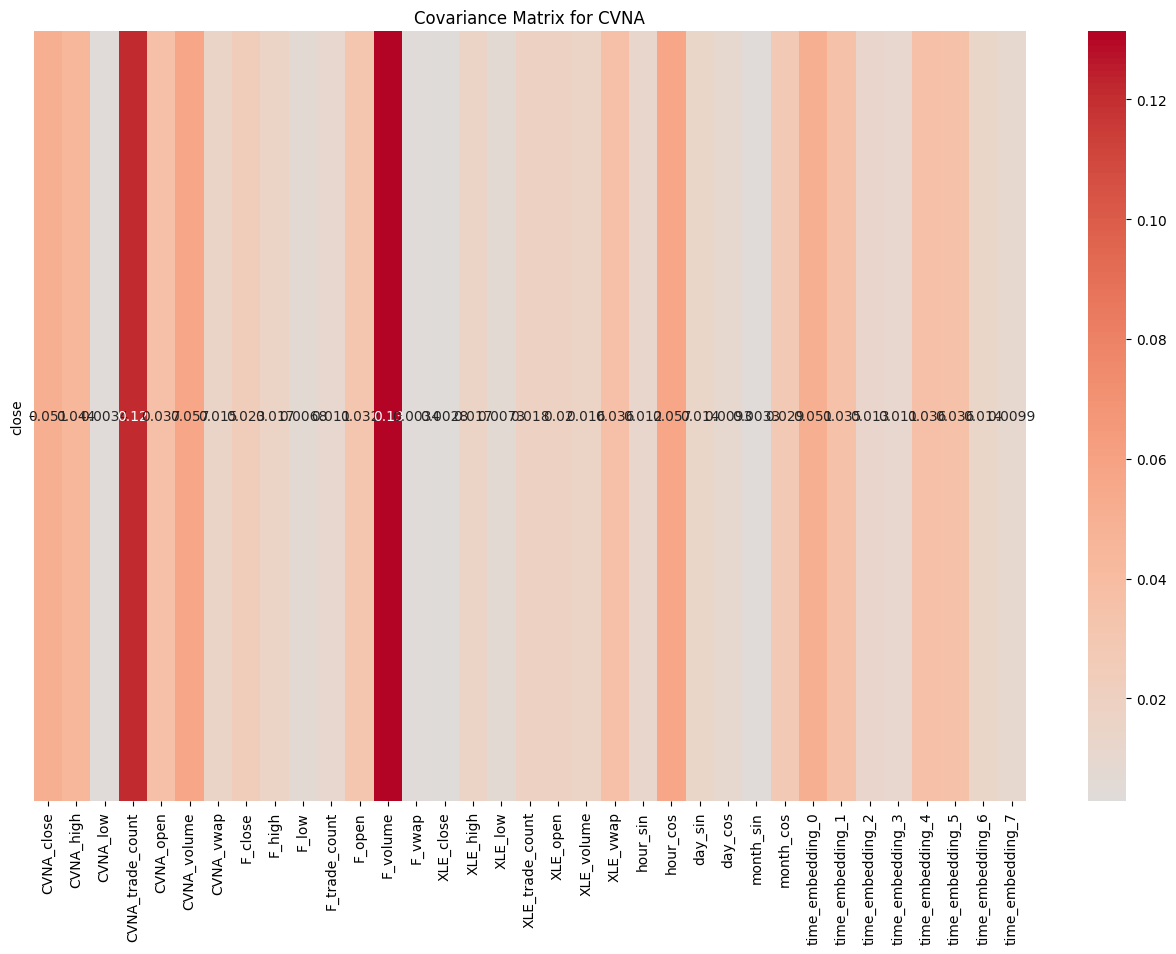

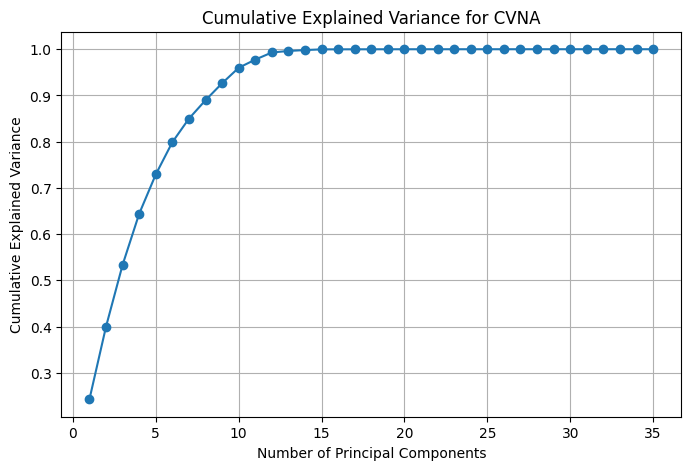

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


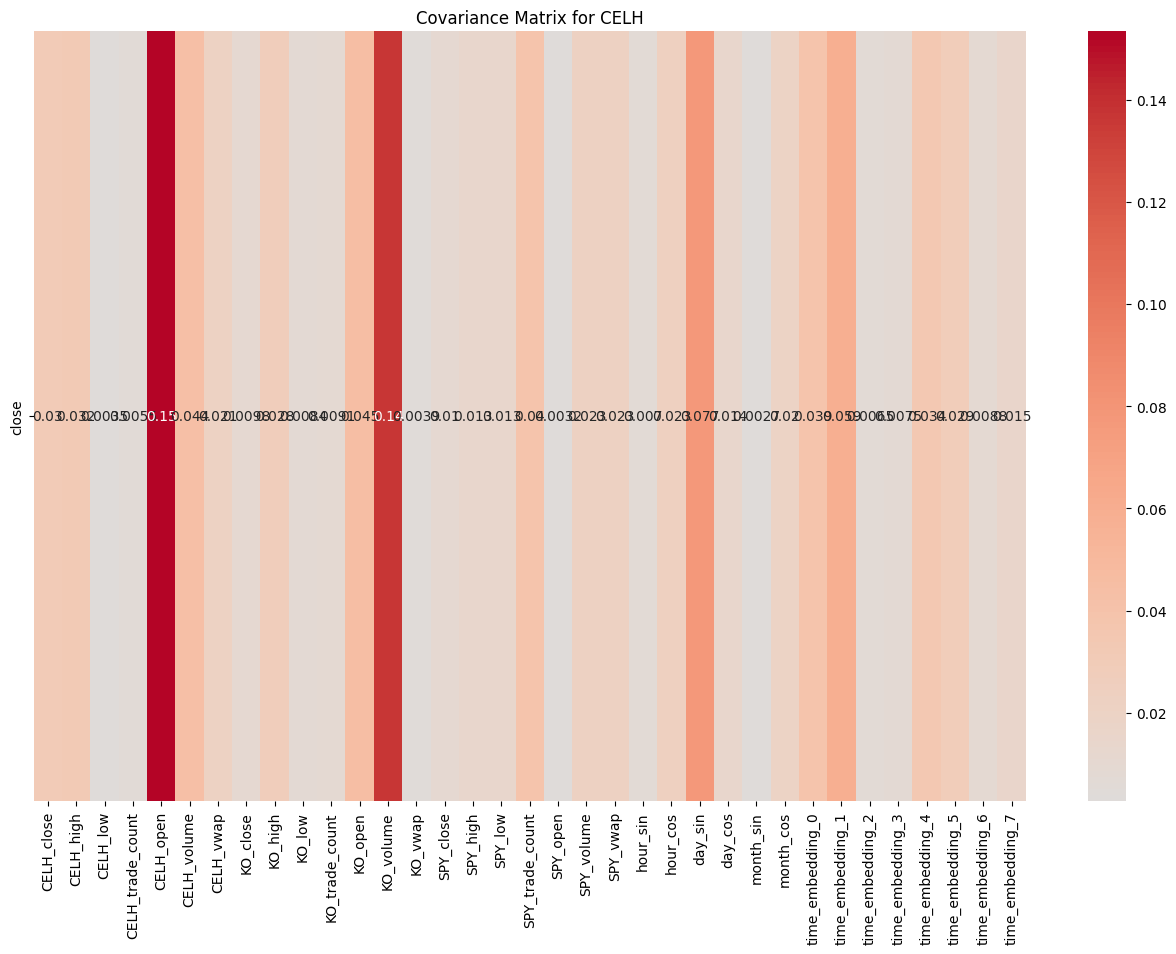

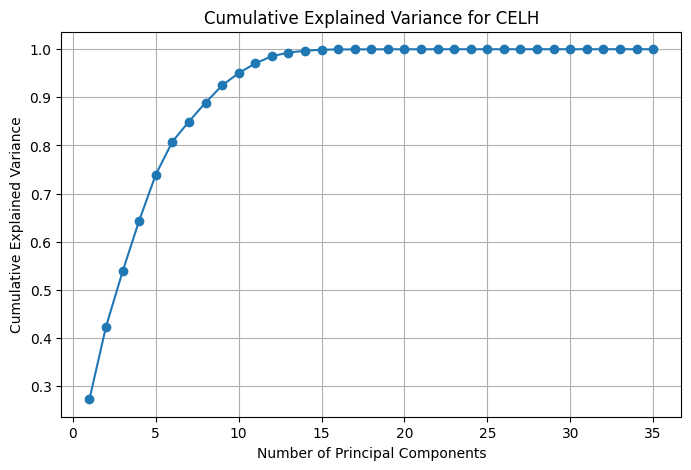

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


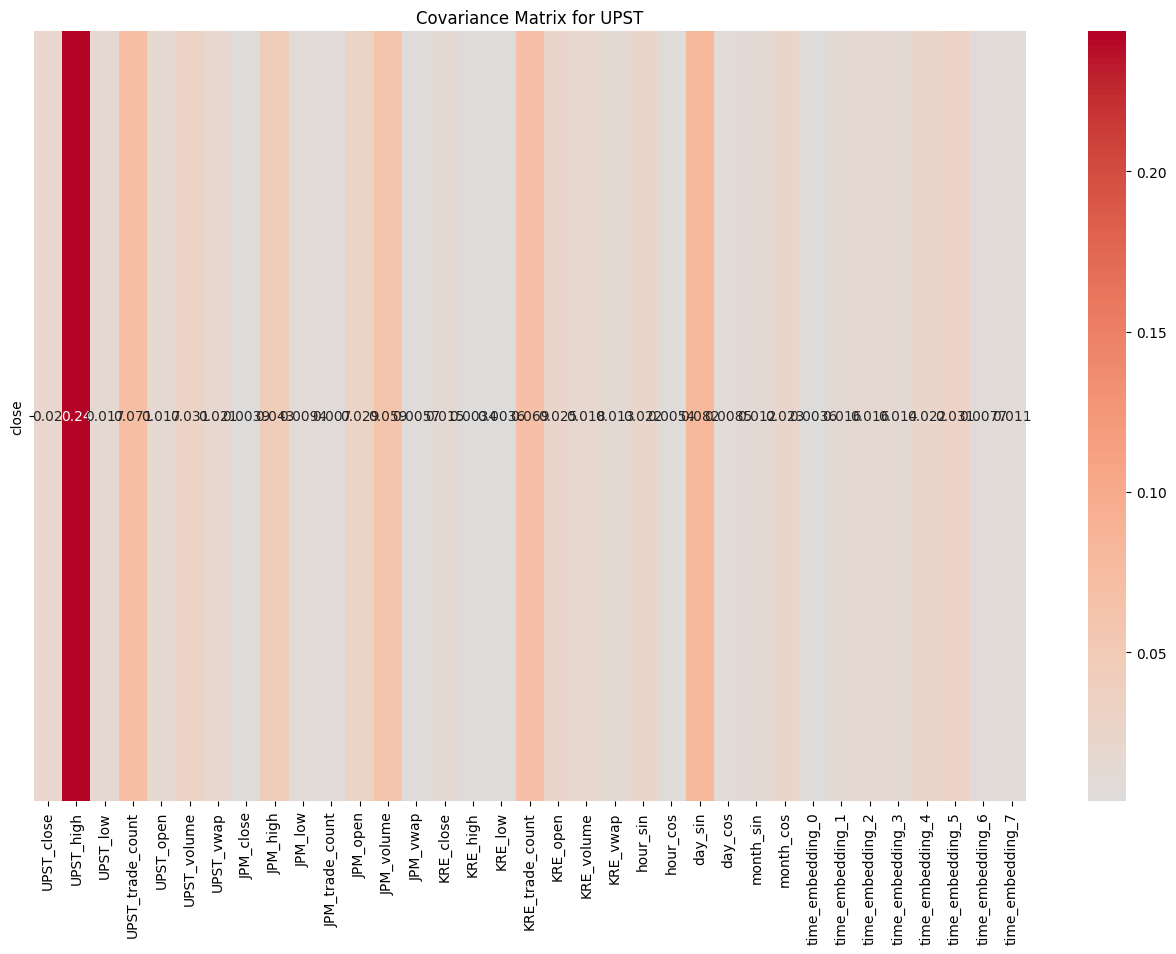

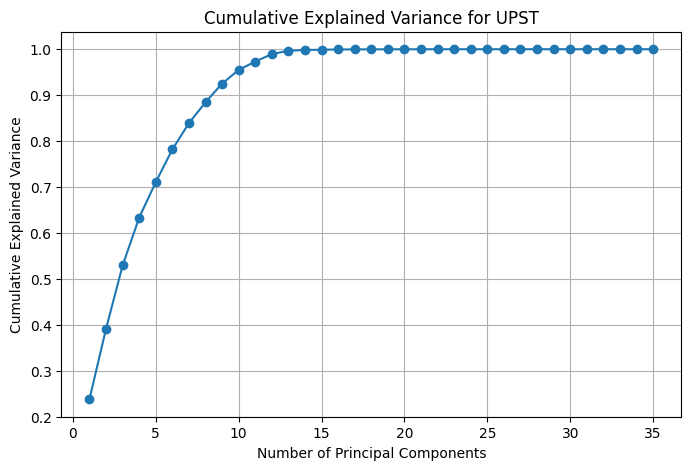

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


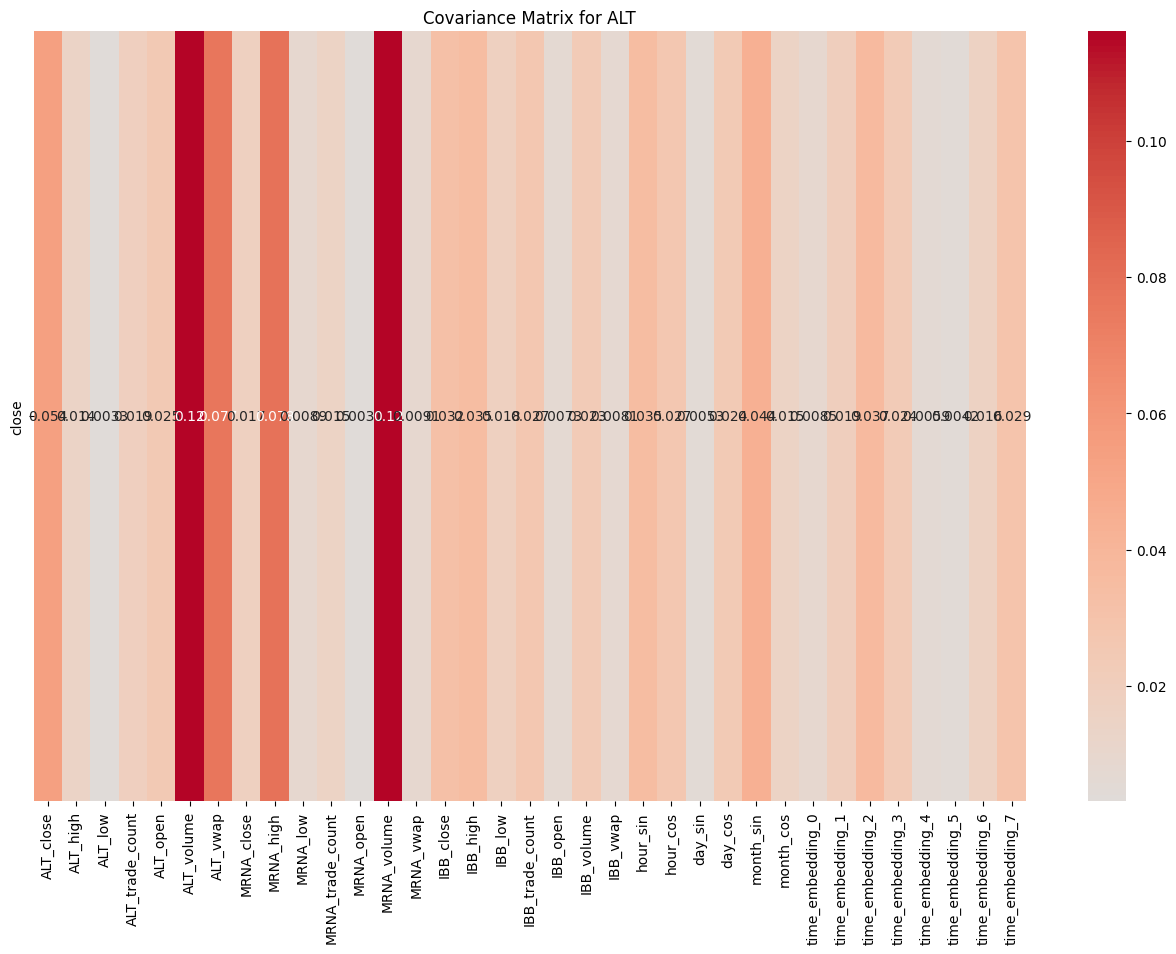

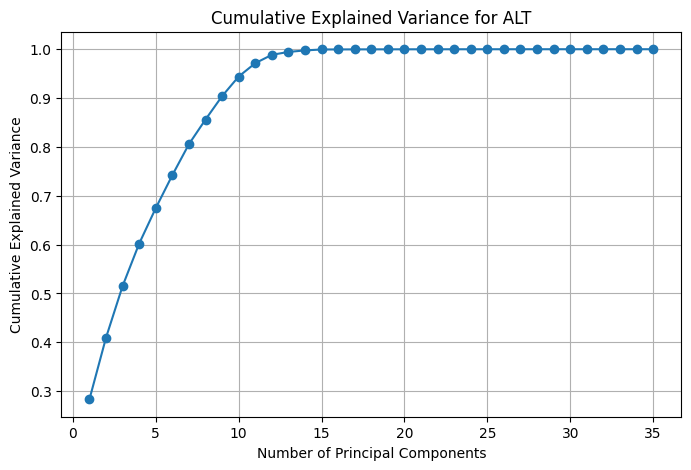

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


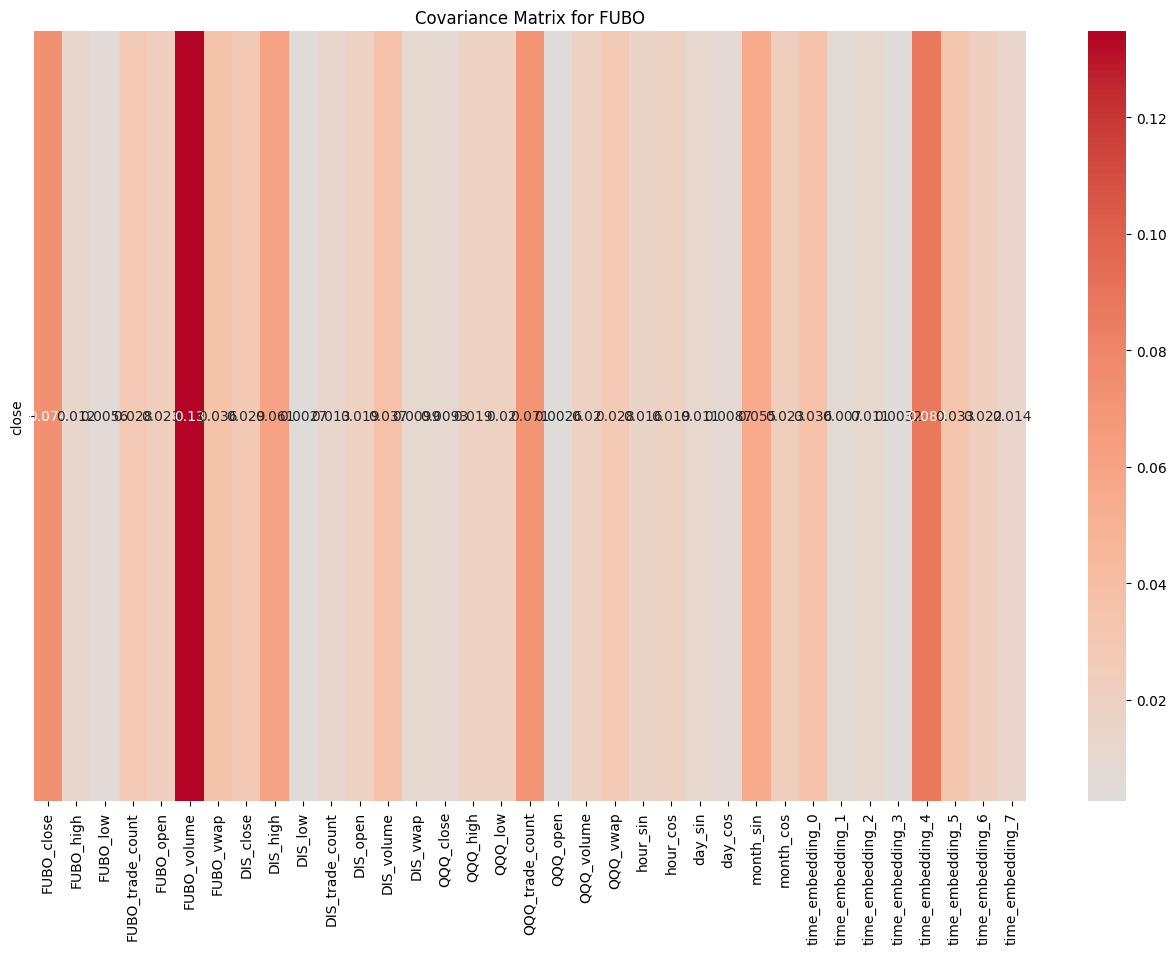

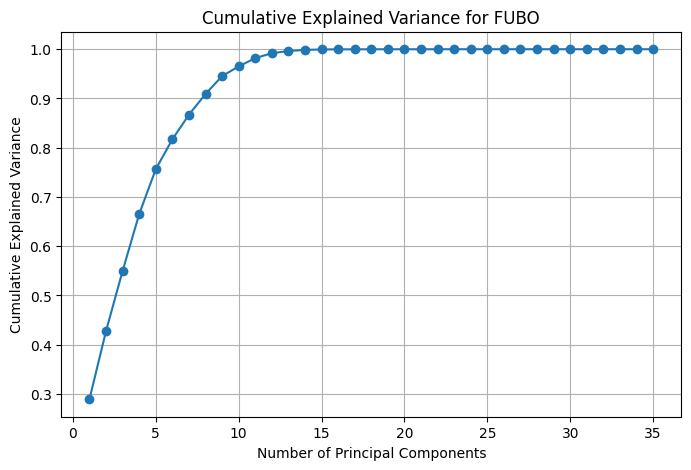

In [11]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_results = {}

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


for ticker, df in dfs_emb.items():

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Apply PCA
    print(list(df.isna().sum()))
    pca = PCA()
    pca_transformed = pca.fit_transform(df_scaled)
    
    # get figure of covariance
    cov = np.abs(softmax(pca.components_.sum(axis=0)))
    plt.figure(figsize=(16, 10))
    # use col names in the x axis
    # plt.xticks(range(len(df.columns)), df.columns, rotation=90)
    sns.heatmap(cov.reshape(1, -1), cmap='coolwarm', center=0, cbar=True, annot=True, xticklabels=df.columns, yticklabels=["close"])
    plt.title(f'Covariance Matrix for {ticker}')
    plt.savefig(f"covariance-{ticker}.png")
    plt.show()

    # print(pca.components_)
    # Store results
    pca_results[ticker] = {
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'pca_transformed': pca_transformed
    }

    #  Display the explained variance ratio per features
    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_.cumsum(), marker='o')
    plt.title(f'Cumulative Explained Variance for {ticker}')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.savefig(f"explained-variance-{ticker}.png")
    plt.show()

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

pca_dfs = {}

for ticker, df in dfs.items():

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    pca = PCA(n_components=10)  # Retain 95% of variance
    df_pca = pca.fit_transform(df_scaled)

    pca_dfs[ticker] = pd.DataFrame(df_pca, columns=[f"PC{i+1}" for i in range(df_pca.shape[1])])

    print(f"{ticker}: {df_pca.shape[1]} principal components retained.")



CVNA: 10 principal components retained.
CELH: 10 principal components retained.
UPST: 10 principal components retained.
ALT: 10 principal components retained.
FUBO: 10 principal components retained.


In [11]:
#Download csv
for ticker, df in pca_dfs.items():
    df.to_csv(f"{ticker}_pca.csv")
    # files.download(f"{ticker}_pca.csv")

# Visualizations


In [12]:
def plot_stock_price(df, ticker_name):
    df['open'].plot(figsize=(12, 6), title=f"{ticker_name} Stock Price")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.show()

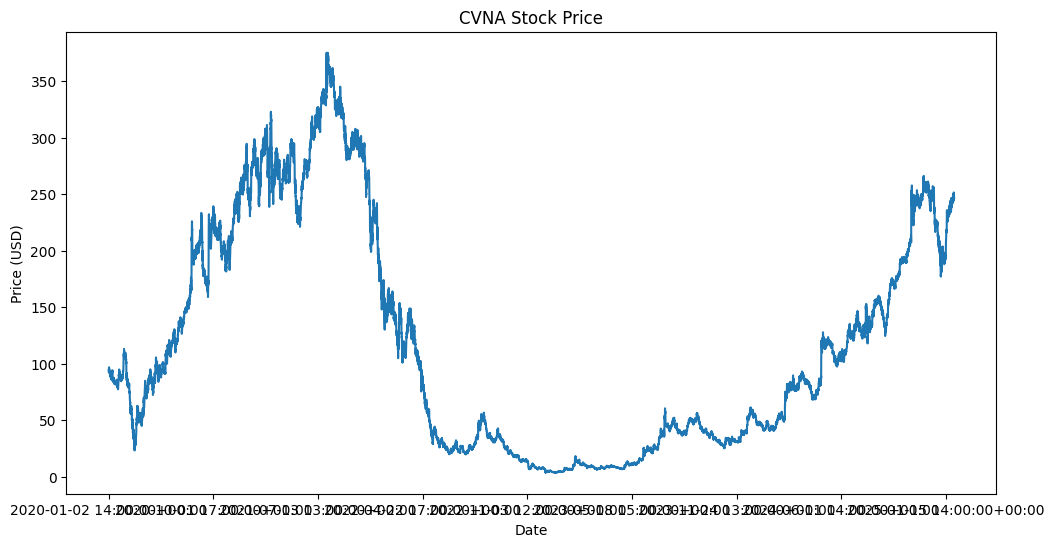

In [13]:
plot_stock_price((dfs[tickers[0]]), tickers[0])

In [15]:
index = 1
dfs[tickers[index]].shape, pca_dfs[tickers[index]].shape

((14217, 46), (14217, 10))

In [17]:
dfs[tickers[index]].columns

Index(['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap', 'year',
       'month', 'day', 'hour', 'CELH_close', 'CELH_high', 'CELH_low',
       'CELH_trade_count', 'CELH_open', 'CELH_volume', 'CELH_vwap', 'KO_close',
       'KO_high', 'KO_low', 'KO_trade_count', 'KO_open', 'KO_volume',
       'KO_vwap', 'SPY_close', 'SPY_high', 'SPY_low', 'SPY_trade_count',
       'SPY_open', 'SPY_volume', 'SPY_vwap', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'time_embedding_0',
       'time_embedding_1', 'time_embedding_2', 'time_embedding_3',
       'time_embedding_4', 'time_embedding_5', 'time_embedding_6',
       'time_embedding_7'],
      dtype='object')

In [18]:
!pip -q install pyts

In [19]:
from pyts.image import GramianAngularField

def get_gaf(past_data, image_size = 16):

    gaf_transformer = GramianAngularField(image_size=image_size, method="difference")
    ts1, ts2, ts3 = past_data[0], past_data[1], past_data[2]
    # Convert each time series to GAF
    gaf1 = gaf_transformer.fit_transform(ts1.reshape(1, -1))[0]  # (64, 64)
    gaf2 = gaf_transformer.fit_transform(ts2.reshape(1, -1))[0]  # (64, 64)
    gaf3 = gaf_transformer.fit_transform(ts3.reshape(1, -1))[0]  # (64, 64)

    # Stack to create a 3-channel image
    gaf_image = np.stack([gaf1, gaf2, gaf3], axis=0)  # Shape: (3, 64, 64)
    return gaf_image

In [20]:
import cv2
def resize_image(image, target_size=(224, 224)):

    target_H, target_W = target_size

    resized_channels = [cv2.resize(image[i], (target_W, target_H), interpolation=cv2.INTER_LINEAR) for i in range(3)]

    return np.stack(resized_channels, axis=0)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm

# Load pre-trained ResNet50 and remove the FC layer
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Removes the FC layer
model.eval()

BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def extract_features_in_batches(data, batch_size):
    all_features = []

    for i in tqdm(range(0, len(data), batch_size), desc="Extracting Features"):
        batch = data[i : i + batch_size]

        batch_tensors = [torch.tensor(x, dtype=torch.float32) for x in batch]
        batch_tensors = torch.stack(batch_tensors).to(device)

        if batch_tensors.ndim == 3:  # If missing the channel dimension
            batch_tensors = batch_tensors.unsqueeze(1)  # Assume grayscale (1 channel)

        with torch.no_grad():
            features = model(batch_tensors)
            features = features.view(features.size(0), -1)  # Flatten features

        all_features.append(features.cpu())

    return torch.cat(all_features, dim=0)


In [37]:
# #Plot gaf
# import matplotlib.pyplot as plt
# gaf = gafs_array2[100]
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# for i in range(3):
#     axs[i].imshow(gaf[i], cmap='viridis')

In [ ]:
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define classification thresholds (adjust based on market volatility)

window_size = 100
look_ahead = 1  # Predict price movement after 10 hours

index = 0

X, y = [], []

df = dfs[tickers[index]]

gafs_array1, gafs_array2, gafs_array3, gafs_array4 = [], [], [], []
for i in tqdm(range(len(df) - window_size - look_ahead)):
    past_data1, past_data2, past_data3, past_data4 = [], [], [], []
    for ticker in tickers_matchings[tickers[index]]:
        # print(ticker)|
        col1 = f"{ticker}_close"
        col2 = f"{ticker}_open"
        col3 = f"{ticker}_volume"
        high_col = f"{ticker}_high"
        low_col = f"{ticker}_low"

        past_data1.append(df.iloc[i:i + window_size, :][col1].values)
        past_data2.append(df.iloc[i:i + window_size, :][col2].values)
        past_data3.append(df.iloc[i:i + window_size, :][col3].values)
        #Difference between High and Low
        past_data4.append(df.iloc[i:i + window_size, :][high_col].values - df.iloc[i:i + window_size, :][low_col].values)


    past_data1 = np.array(past_data1)
    past_data2 = np.array(past_data2)
    past_data3 = np.array(past_data3)
    past_data4 = np.array(past_data4)

    gaf_array1 = resize_image(get_gaf(past_data1))
    gaf_array2 = resize_image(get_gaf(past_data2))
    gaf_array3 = resize_image(get_gaf(past_data3))
    gaf_array4 = resize_image(get_gaf(past_data4))

    gafs_array1.append(gaf_array1)
    gafs_array2.append(gaf_array2)
    gafs_array3.append(gaf_array3)
    gafs_array4.append(gaf_array4)

In [ ]:
gafs_array1 = np.array(gafs_array1)
gafs_array2 = np.array(gafs_array2)
gafs_array3 = np.array(gafs_array3)
gafs_array1.shape, gafs_array2.shape, gafs_array3.shape

((1177, 3, 224, 224), (1177, 3, 224, 224), (1177, 3, 224, 224))

In [ ]:
torch.cuda.is_available()

True

In [ ]:
BATCH_SIZE = 2
feature_vectors = extract_features_in_batches(gafs_array1, BATCH_SIZE)
feature_vectors = torch.cat((feature_vectors, extract_features_in_batches(gafs_array2, BATCH_SIZE)), dim=1)
feature_vectors = torch.cat((feature_vectors, extract_features_in_batches(gafs_array3, BATCH_SIZE)), dim=1)
feature_vectors = torch.cat((feature_vectors, extract_features_in_batches(gafs_array4, BATCH_SIZE)), dim=1)
feature_vectors.shape

Extracting Features: 100%|██████████| 589/589 [00:05<00:00, 115.84it/s]


torch.Size([1177, 8192])

In [ ]:
feature_vectors = feature_vectors.numpy()

In [ ]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from collections import Counter

# Define classification thresholds
threshold = 0.01  # 0.1% price change threshold for binary classification

window_size = 100
look_ahead = 1  # Predict price movement after 5 time steps

index = 0
X, y = [], []

df = dfs[tickers[index]]

# Feature extraction
for i in tqdm(range(len(df) - window_size - look_ahead)):
    feature_vector = feature_vectors[i]
    present_price = df.iloc[i + window_size]["close"]
    future_price = df.iloc[i + window_size + look_ahead]["close"]

    # Calculate price movement percentage
    price_change = (future_price - present_price) / present_price

    # Binary labels: 1 = Up, 0 = Down
    cur_label = 1 if price_change > threshold else 0

    X.append(feature_vector)
    y.append(cur_label)

X = np.array(X)
y = np.array(y)

# Flatten X
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X before PCA: {X_flat.shape}, Shape of y: {y.shape}")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Apply PCA
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

print(f"Shape of X after PCA: {X_pca.shape}")

# Compute class imbalance ratio for XGBoost & LightGBM
counter = Counter(y)
num_neg = counter[0]
num_pos = counter[1]
scale_pos_weight = num_neg / num_pos
print(f"Computed scale_pos_weight: {scale_pos_weight:.2f}")

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.5,
    reg_lambda=2.0,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=2.0,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Define LightGBM model
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.5,
    reg_lambda=2.0,
    subsample=0.7,
    colsample_bytree=0.7
)

# Walk-forward validation function
def walk_forward_validation(X, y, models, test_size_ratio=0.2):
    test_size = int(len(X) * test_size_ratio)
    scores = {model_name: [] for model_name in models}

    for i in range(5):  # Five train-test splits
        train_end = len(X) - (test_size * (5 - i))
        X_train, y_train = X[:train_end], y[:train_end]
        X_test, y_test = X[train_end:], y[train_end:]

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            scores[model_name].append(acc)

    return {model: (np.mean(scores[model]), np.std(scores[model])) for model in scores}

# Run walk-forward validation on both models
models = {"XGBoost": xgb_model}
results = walk_forward_validation(X_pca, y, models)

# Print results
for model, (mean_acc, std_acc) in results.items():
    print(f"\n{model} Walk-Forward Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


100%|██████████| 1177/1177 [00:00<00:00, 3571.69it/s]


Shape of X before PCA: (1177, 8192), Shape of y: (1177,)
Shape of X after PCA: (1177, 915)
Computed scale_pos_weight: 1.58


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


XGBoost Walk-Forward Accuracy: 0.5602 ± 0.0279
